## Scaling Factor sanity check
This compares the scaling factor theoretical estimates for the individual physical mechanism contributions to the numerical value.
They differ because the theory only includes the linear contribution i.e. $\delta T_{FT}$,
but in reality higher order terms $\delta (T_{FT})^n$ will be present, and are captured in the numerical estimate.

Here, we just use toy data, to give a sizeable scaling factor contribution from each mechanism.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.utils.constants import R
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, get_scale_factor_theory
import inspect

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
def get_temp(rh, p_surf, lapse_D=0, lapse_M=0, sCAPE=None, temp_surf=None, temp_ft=None):
    # Has useful default values as ref in cold climate. So to find effect of a mechanism, just
    # change that variable.
    # Still gives option to compute surf or FT temp
    if sCAPE is not None:
        lapse_D = 0
        lapse_M = 0
        R_mod = R / 2 * np.log(p_surf / sf_var['p_ft'])
        temp_ft_dev = sCAPE / R_mod  # Value of T_ft_parc - T_ft_env given formula for sCAPE
        if temp_surf is None:
            # When finding surface temperature, use parcel temperature at FT, then follow parcel profile to surface
            # with lapse_D = 0; lapse_M=0.
            temp_ft = temp_ft + temp_ft_dev

    temp_sol = get_temp_mod_parcel(rh, p_surf, sf_var['p_ft'], lapse_D, lapse_M, temp_surf, temp_ft,
                                   lapse_coords='lnp',
                                   temp_surf_lcl_calc=sf_var['temp_surf_lcl_calc'])
    if (sCAPE is not None) and (temp_surf is not None):
        # In this case, will have computed the parcel temperature at the FT
        # Get environmental temperature from parcel by subtracting (T_ft_parc - T_ft_env)
        temp_sol = temp_sol - temp_ft_dev
    return temp_sol


get_temp = np.vectorize(get_temp)

In [18]:
n_quant = 21
temp_surf_ref_change = 5
temp_surf_anom = np.linspace(-10, 10, n_quant)  # max anom of 5K in the current climate
rh_quant_anom = np.linspace(-0.2, 0.2, n_quant)  # max anom of 20% in current climate
rh_quant_change = np.linspace(-0.01, 0.01, n_quant) * temp_surf_ref_change  # max change of 1% per Kelvin
temp_ft_quant_change = np.linspace(1, 1.8, n_quant) * temp_surf_ref_change  # max change of 1.85K per Kelvin, min of 1K per Kelvin
p_surf_quant_anom = np.linspace(-200, 200, n_quant) * 100  # max anom of 200hPa in current climate
p_surf_quant_change = np.linspace(-3, 3, n_quant) * 100 * temp_surf_ref_change  # max change of 3hPa per Kelvin
lapse_D_quant = np.linspace(-50, 50, n_quant)  # max anom in the current climate of 50K (around 5K/km)
lapse_D_quant_change = np.linspace(-0.75, 0.75, n_quant) * temp_surf_ref_change  # max change of 1K per Kelvin (around 0.1K/km per Kelvin)
lapse_M_quant = np.linspace(-50, 50, n_quant)
lapse_M_quant_change = np.linspace(-0.75, 0.75, n_quant) * temp_surf_ref_change

sf_var = {'temp_surf_ref': np.array([300, 300 + temp_surf_ref_change]),
          'rh_ref': 0.5, 'p_ft': 500 * 100,
          'p_surf_ref': 1000 * 100, 'temp_surf_lcl_calc': 300, 'lapse_coords': 'lnp'
          }

sf_var['rh_quant'] = sf_var['rh_ref'] + np.vstack([rh_quant_anom, rh_quant_anom + rh_quant_change])
sf_var['p_surf_quant'] = sf_var['p_surf_ref'] + np.vstack([p_surf_quant_anom, p_surf_quant_anom + p_surf_quant_change])
sf_var['lapse_D_quant'] = np.vstack([lapse_D_quant, lapse_D_quant + lapse_D_quant_change])
sf_var['lapse_M_quant'] = np.vstack([lapse_M_quant, lapse_M_quant + lapse_M_quant_change])

# Compute temperatures using mod_parcel formulae
temp_surf_quant0 = sf_var['temp_surf_ref'][0] + temp_surf_anom  # Know temp_surf_quant in base climate
# Compute temp_ft_quant in base climate from all other parameters
temp_ft_quant0 = get_temp(sf_var['rh_quant'][0], sf_var['p_surf_quant'][0], sf_var['lapse_D_quant'][0],
                          sf_var['lapse_M_quant'][0], temp_surf=temp_surf_quant0)
# Know change in temp_ft with warming so know temp_ft in both climates
sf_var['temp_ft_quant'] = np.vstack([temp_ft_quant0, temp_ft_quant0 + temp_ft_quant_change])
# Given temp_ft and all other variables in warm climate, compute temp_surf in warm climate
temp_surf_quant1 = get_temp(sf_var['rh_quant'][1], sf_var['p_surf_quant'][1], sf_var['lapse_D_quant'][1],
                            sf_var['lapse_M_quant'][1], temp_ft=sf_var['temp_ft_quant'][1])
sf_var['temp_surf_quant'] = np.vstack([temp_surf_quant0, temp_surf_quant1])

sf_cont = get_scale_factor_theory_numerical2(**sf_var)[3]

# Get theoretical estimate
valid_params = inspect.signature(get_scale_factor_theory).parameters.keys()
kwargs = {k: v for k, v in sf_var.items() if k in valid_params}
sf_cont_theory = get_scale_factor_theory(**kwargs)[-1]
sf_cont_theory['lapse_M_anom'] = sf_cont_theory['lapse_M_change']*0+1       # estimate for lapse_M_anom is no effect

In [19]:
# Contribution from sCAPE - need to calculate separately
sCAPE_quant = np.linspace(-500, 500, n_quant)                               # max anom in the current climate of 500J/kg
sCAPE_quant_change = np.linspace(-30, 30, n_quant) * temp_surf_ref_change   # max change with warming of 30J/kg per Kelvin

sf_var['sCAPE_quant'] = np.vstack([sCAPE_quant, sCAPE_quant + sCAPE_quant_change])

# Compute temperatures using mod_parcel formulae
temp_ft_quant0 = get_temp(sf_var['rh_quant'][0], sf_var['p_surf_quant'][0], sCAPE=sf_var['sCAPE_quant'][0],
                          temp_surf=temp_surf_quant0)
# Know change in temp_ft with warming so know temp_ft in both climates
sf_var['temp_ft_quant'] = np.vstack([temp_ft_quant0, temp_ft_quant0 + temp_ft_quant_change])
# Given temp_ft and all other variables in warm climate, compute temp_surf in warm climate
temp_surf_quant1 = get_temp(sf_var['rh_quant'][1], sf_var['p_surf_quant'][1], sCAPE=sf_var['sCAPE_quant'][1],
                            temp_ft=sf_var['temp_ft_quant'][1])
sf_var['temp_surf_quant'] = np.vstack([temp_surf_quant0, temp_surf_quant1])

# Remove lapse info
for key in ['lapse_D_quant', 'lapse_M_quant']:
    if key in sf_var:
        del sf_var[key]

cont_sCAPE = get_scale_factor_theory_numerical2(**sf_var)[3]
sf_cont['sCAPE_change'] = cont_sCAPE['sCAPE_change']
sf_cont['sCAPE_anom'] = cont_sCAPE['sCAPE_anom']

kwargs = {k: v for k, v in sf_var.items() if k in valid_params}
cont_theory_sCAPE = get_scale_factor_theory(**kwargs)[-1]
sf_cont_theory['sCAPE_change'] = cont_theory_sCAPE['sCAPE_change']
sf_cont_theory['sCAPE_anom'] = sf_cont_theory['sCAPE_change']*0+1       # estimate for sCAPE_anom is no effect

In [128]:
x_var = {'temp_ft_change': (temp_ft_quant_change-temp_ft_quant_change.mean()) / (temp_ft_quant_change-temp_ft_quant_change.mean()).max(),
         'rh_change': rh_quant_change / rh_quant_change.max(),
         'p_surf_change': p_surf_quant_change / p_surf_quant_change.max(),
         'sCAPE_change': sCAPE_quant_change / sCAPE_quant_change.max(),
         'lapse_D_change': lapse_D_quant_change/lapse_D_quant_change.max(),
         'lapse_M_change': lapse_M_quant_change/lapse_M_quant_change.max(),
         'temp_surf_anom': temp_surf_anom / temp_surf_anom.max(),
         'rh_anom': rh_quant_anom / rh_quant_anom.max(),
         'p_surf_anom': p_surf_quant_anom / p_surf_quant_anom.max(),
         'sCAPE_anom': sCAPE_quant / sCAPE_quant.max(),
         'lapse_D_anom': lapse_D_quant/lapse_D_quant.max(),
         'lapse_M_anom': lapse_M_quant/lapse_M_quant.max()}

print('Normalisation factors\n')
print(f'temp_ft_change: Subtract {temp_ft_quant_change.mean()/temp_surf_ref_change:.2f}K/K '
      f'then divide by {temp_ft_quant_change.max()/temp_surf_ref_change - temp_ft_quant_change.mean()/temp_surf_ref_change:.2f}K/K. '
      f'I.e. goes from {temp_ft_quant_change.min()/temp_surf_ref_change}K/K to {temp_ft_quant_change.max()/temp_surf_ref_change}K/K')
print(f'rh_change: {rh_quant_change.max()*100/temp_surf_ref_change:.2f}%/K')
print(f'p_surf_change: {p_surf_quant_change.max()/100/temp_surf_ref_change:.2f}hPa/K')
print(f'sCAPE_change: {sCAPE_quant_change.max()/temp_surf_ref_change:.2f}(J/kg)/K')
print(f'lapse_D_change: {lapse_D_quant_change.max()/temp_surf_ref_change:.2f}K/K')
print(f'lapse_M_change: {lapse_M_quant_change.max()/temp_surf_ref_change:.2f}K/K\n')
print(f'temp_surf_anom: {temp_surf_anom.max()}K')
print(f'rh_anom: {rh_quant_anom.max()*100}%')
print(f'p_surf_anom: {p_surf_quant_anom.max()/100}hPa')
print(f'sCAPE_anom: {sCAPE_quant.max()}J/kg')
print(f'lapse_D_anom: {lapse_D_quant.max():.2f}K')
print(f'lapse_M_anom: {lapse_M_quant.max():.2f}K')

Normalisation factors

temp_ft_change: Subtract 1.40K/K then divide by 0.40K/K. I.e. goes from 1.0K/K to 1.8K/K
rh_change: 1.00%/K
p_surf_change: 3.00hPa/K
sCAPE_change: 30.00(J/kg)/K
lapse_D_change: 0.75K/K
lapse_M_change: 0.75K/K

temp_surf_anom: 10.0K
rh_anom: 20.0%
p_surf_anom: 200.0hPa
sCAPE_anom: 500.0J/kg
lapse_D_anom: 50.00K
lapse_M_anom: 50.00K


In [84]:
colors = {'temp_ft': 'C2', 'rh': 'C0', 'p_surf': 'C4', 'sCAPE': 'C1',
          'lapse_M': 'C1', 'lapse_D': 'C8',
          'temp_surf': 'C3', 'rh_anom': 'C0'}
labels = {'temp_ft': '$T_{FT}$', 'rh': '$r_s$', 'p_surf': '$p_s$', 'sCAPE': 'sCAPE',
          'temp_surf': '$T_s$', 'lapse_D': '$\eta_D$', 'lapse_M': '$\eta_M$'}

leg_handlelength=1.5

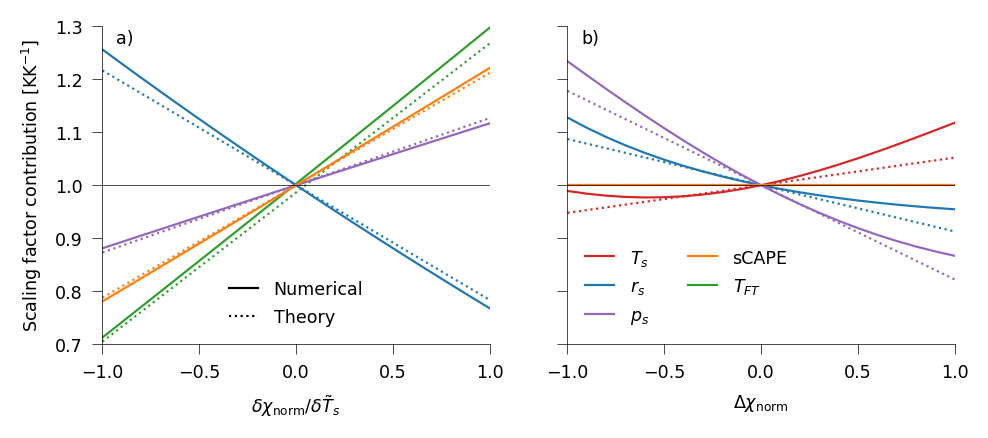

In [133]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for key in x_var:
    if 'lapse' in key:
        continue
    if 'change' in key:
        ax[0].plot(x_var[key], sf_cont[key], color=colors[key.replace('_change', '')])
        ax[0].plot(x_var[key], sf_cont_theory[key], color=colors[key.replace('_change', '')], linestyle=':')
    if 'anom' in key:
        ax[1].plot(x_var[key], sf_cont[key], color=colors[key.replace('_anom', '')], label=labels[key.replace('_anom', '')])
        ax[1].plot(x_var[key], sf_cont_theory[key], color=colors[key.replace('_anom', '')], linestyle=':')
ax[1].plot(-2, -2, color=colors['temp_ft'], label=labels['temp_ft'])
ax[0].plot(-2, -2, color='k', label='Numerical')
ax[0].plot(-2, -2, color='k', linestyle=':', label='Theory')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(0.7, 1.3)
ax[0].set_xlabel('$\delta \chi_{\\text{norm}}$')
ax[1].set_xlabel('$\Delta \chi_{\\text{norm}}$')
update_linewidth(fig)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].legend(handlelength=leg_handlelength)
ax[0].set_ylabel('Scaling factor contribution [KK$^{-1}$]')
ax[1].legend(ncol=2, handlelength=leg_handlelength)
label_subplots(fig, ax, pos_y=-1)
update_fontsize(fig)
plt.show()
# savefig(fig)

### modParc Formulation
This assesses the additional mechanisms in the modified parcel framework.

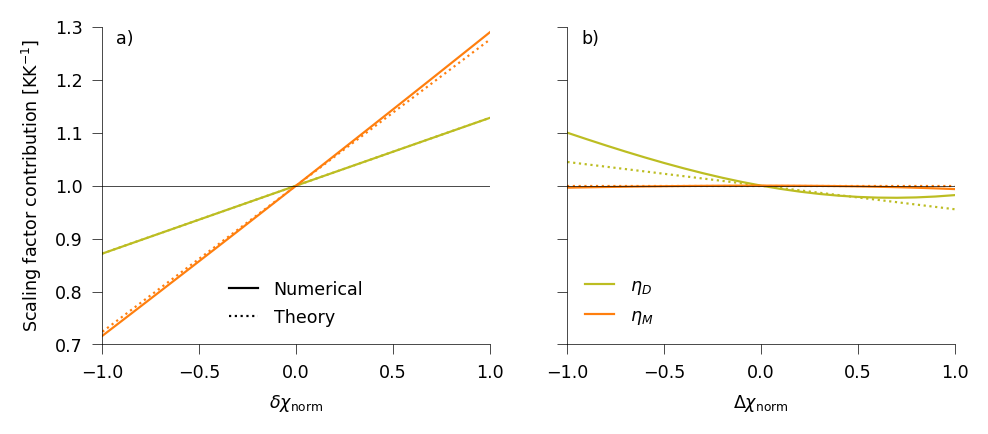

In [135]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for key in x_var:
    if 'lapse' not in key:
        continue
    if 'change' in key:
        ax[0].plot(x_var[key], sf_cont[key], color=colors[key.replace('_change', '')])
        ax[0].plot(x_var[key], sf_cont_theory[key], color=colors[key.replace('_change', '')], linestyle=':')
    if 'anom' in key:
        ax[1].plot(x_var[key], sf_cont[key], color=colors[key.replace('_anom', '')], label=labels[key.replace('_anom', '')])
        ax[1].plot(x_var[key], sf_cont_theory[key], color=colors[key.replace('_anom', '')], linestyle=':')
ax[0].plot(-2, -2, color='k', label='Numerical')
ax[0].plot(-2, -2, color='k', linestyle=':', label='Theory')
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(0.7, 1.3)
update_linewidth(fig)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel('$\delta \chi_{\\text{norm}}$')
ax[1].set_xlabel('$\Delta \chi_{\\text{norm}}$')
label_subplots(fig, ax, pos_y=-1)
ax[0].set_ylabel('Scaling factor contribution [KK$^{-1}$]')
ax[0].legend(loc='lower center', handlelength=leg_handlelength)
ax[1].legend(loc='lower left', handlelength=leg_handlelength)
update_fontsize(fig)
plt.show()
# savefig(fig)